In [149]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function

In [150]:
"""
I will create two datasets of one dimensional gaussian. Pass it through separate VAE. Do Gibbs sampling and see 
if I can learn true latent space
""" 

def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)

In [151]:
## Creating synthetic datasets
nb_samples=5000
mu1  =torch.tensor(1.)   # . converts long to float
var1 =torch.tensor(2.1)
mu2  =torch.tensor(2.)   # . converts long to float
var2 =torch.tensor(3.1)

inp_data1=sample(mu1,var1,nb_samples)
inp_data1=inp_data1.unsqueeze(0)
inp_data1=torch.transpose(inp_data1,0,1)

inp_data2=sample(mu2,var2,nb_samples)
inp_data2=inp_data2.unsqueeze(0)
inp_data2=torch.transpose(inp_data2,0,1)

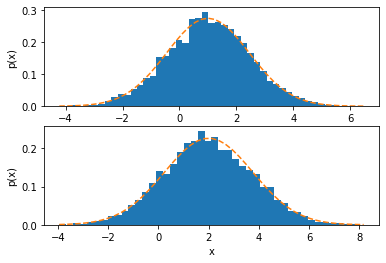

mu1 tensor(1.)
var1 tensor(2.1000)
mu2 tensor(2.)
var2 tensor(3.1000)


In [152]:
## for data visualization
data_vis1=inp_data1.numpy()
data_vis2=inp_data2.numpy()

fig, ax = plt.subplots(2,1)

#flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
#Panel a
n1,bins1,patches1=ax[0].hist(data_vis1,'auto',density=1)
y1=1/(np.sqrt(2*np.pi*var1))*np.exp(-0.5*(bins1-mu1.numpy())**2/var1)
ax[0].plot(bins1,y1,'--')
ax[0].set(xlabel='x',ylabel='p(x)')
#Panel b
n2,bins2,patches2=ax[1].hist(data_vis2,'auto',density=1)
y2=1/(np.sqrt(2*np.pi*var2))*np.exp(-0.5*(bins2-mu2.numpy())**2/var2)
ax[1].plot(bins2,y2,'--')
ax[1].set(xlabel='x',ylabel='p(x)')

plt.show()
print("mu1",mu1)
print("var1",var1)
print("mu2",mu2)
print("var2",var2)

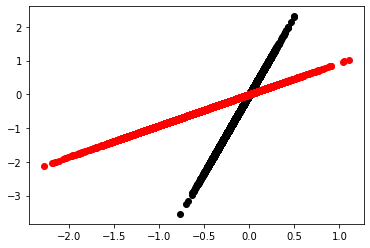

In [153]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2 
fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
data1    = inp_data1*fun_A1
data2    = inp_data2*fun_A2
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

In [154]:
## Hyperparameters
epochs     = 10
batch_size = 128
lr         = 1e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [155]:
## Creating synthetic dataloader

train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [156]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)

latent_dim1 = 1
latent_dim2 = 1

class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.gibbs                   = gibbs_sampler.gibbs_sampler()        
        ## Encoder set1
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim1)
        self.set1_enc2 = nn.Linear(in_features = 2*latent_dim1,out_features = 2*latent_dim1)
        ## Encoder set2
        self.set2_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim2)
        self.set2_enc2 = nn.Linear(in_features = 2*latent_dim2,out_features = 2*latent_dim2)
        ## Decoder set1
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = dim_exp,bias=False)
        ## Decoder set2
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = dim_exp,bias=False)
    
    def forward(self,x1,x2):
        data1    = x1
        data2    = x2
        ## encoding
        x1       = F.relu(self.set1_enc1(x1))
        x1       = self.set1_enc2(x1)
        x2       = F.relu(self.set2_enc1(x2))
        x2       = self.set2_enc2(x2)
        mu1      = x1[:,0]
        mu1      = mu1.unsqueeze(0)
        mu1      = torch.transpose(mu1,0,1)    
        log_var1 = x1[:,1]
        var1     = torch.exp(log_var1)
        var1     = var1.unsqueeze(0)
        var1     = torch.transpose(var1,0,1)    
        mu2      = x2[:,0]
        mu2      = mu2.unsqueeze(0)
        mu2      = torch.transpose(mu2,0,1)    
        log_var2 = x2[:,1]
        var2     = torch.exp(log_var2)
        var2     = var2.unsqueeze(0)
        var2     = torch.transpose(var2,0,1) 
        G,z1,z2,z1_prior,z2_prior = self.gibbs.calc(mu1,var1,mu2,var2)

        ## Creating Sufficient statistics
        T1_prior = torch.cat((z1_prior,torch.square(z1_prior)),1)     #sufficient statistics for prior of set1
        T2_prior = torch.cat((z2_prior,torch.square(z2_prior)),1)     #sufficient statistics for prior of set2
        T1_post = torch.cat((z1,torch.square(z1)),1)                  #sufficient statistics for posterior of set1
        T2_post = torch.cat((z2,torch.square(z2)),1)                  #sufficient statistics for posterior of set2
        lambda1 = torch.cat((mu1,var1),1)                             #Output of encoder for set1
        lambda2 = torch.cat((mu2,var2),1)                             #Output of encoder for set2        
        T_prior_sqrd = torch.sum(torch.square(z1_prior),1) +torch.sum(torch.square(z2_prior),1) #stores z^2+z'^2
        T_post_sqrd  = torch.sum(torch.square(z1),1) +torch.sum(torch.square(z2),1)
        # Sampling from logp(z,z')
        log_p_prior = -T_prior_sqrd+torch.matmul(torch.matmul(T1_prior,G),torch.transpose(T2_prior,0,1))
        # Sampling from log_q(z,z'|x,x')
        log_q_post  = -T_post_sqrd+torch.matmul(torch.matmul(T1_post,G),torch.transpose(T2_post,0,1))
        
        #Calculating KL divergence terms
        part_fun0 = torch.sum(torch.diagonal(log_q_post-log_p_prior,0))
        part_fun1 = -torch.sum(torch.mul(lambda1,T1_post))-torch.sum(torch.mul(lambda2,T2_post)) #-lambda*Tq-lambda'Tq'
        T1_prior  = T1_prior.unsqueeze(2)
        T2_prior  = T2_prior.unsqueeze(2)
        T1_post   = T1_post.unsqueeze(1)
        T2_post   = T2_post.unsqueeze(1)
        part_fun2 = torch.sum(torch.mul(T1_prior*T2_prior,G))-torch.sum(torch.mul(T1_post*T2_post,G))            
        ## decoding

        reconstruction1=self.set1_dec1(z1)
        reconstruction2=self.set2_dec1(z2)
        
        ## loss
        mse_loss = nn.MSELoss(reduction='sum')
        MSE1 = mse_loss(reconstruction1, data1)
        MSE2 = mse_loss(reconstruction2, data2)
        KLD = part_fun0+part_fun1+part_fun2
        loss= MSE1+MSE2+KLD
        print("part_fun0",part_fun0)
        print("part_fun0",part_fun0)
        print("KLD",part_fun0)

        return mu1,log_var1,mu2,log_var2,loss
    
    

In [157]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)

In [158]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(device)
        data2                        = data2.to(device)        
        mu1,log_var1,mu2,log_var2,loss = model(data1,data2)     
        running_loss                += loss.item()
        loss.backward()                      
        optimizer.step()
    print(len(dataloader1.dataset)+len(dataloader2.dataset))

    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(device)
            data2                        = data2.to(device)        
            mu1,log_var1,mu2,log_var2,loss = model(data1,data2)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(torch.exp(log_var1))]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(torch.exp(log_var2))]
    print(len(dataloader1.dataset)+len(dataloader2.dataset))
    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [159]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set1)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

Epoch 1 of 10
KLD tensor(-16.1219, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-22.6844, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(4.2121, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(32.2653, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-7.5764, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(2.8751, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-7.3167, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(7.1490, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(15.2694, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-2.8519, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-10.4917, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(29.5231, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-12.3879, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-20.2223, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(26.4415, device='cuda:0', grad_fn=<AddBackward0>)
KLD tensor(-12.4858, device='cuda:0', grad_fn=<AddBackward0>)
KLD ten

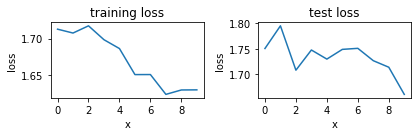

In [135]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

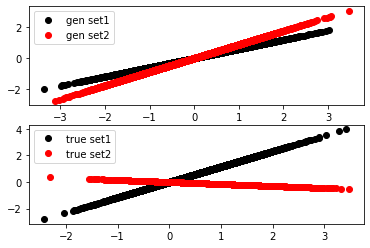

In [148]:
## Transforming data to a higher dimension
mean_pred  =torch.tensor(0.).cpu()   # . converts long to float
var_pred =torch.tensor(1.0).cpu()
gen_data  = sample(mean_pred,var_pred,nb_samples)
gen_data  = gen_data.unsqueeze(1)

"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
#fun_A   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
A=list(model.named_parameters())
A1=A[-2]
A2=A[-1]
m1,set1_dec1_wgt=A1
m2,set2_dec1_wgt=A2

set1_dec1_wgt  = (torch.transpose(set1_dec1_wgt,0,1)).cpu()
set2_dec1_wgt  = (torch.transpose(set2_dec1_wgt,0,1)).cpu()

data1_sim= gen_data*set1_dec1_wgt
data2_sim= gen_data*set2_dec1_wgt

dat1_x_cord = data1_sim[:,0].cpu().detach().numpy()
dat1_y_cord = data1_sim[:,1].cpu().detach().numpy()
dat2_x_cord = data2_sim[:,0].cpu().detach().numpy()
dat2_y_cord = data2_sim[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)
ax[0].plot(dat1_x_cord,dat1_y_cord, 'o', color='black',label='gen set1')
ax[0].plot(dat2_x_cord,dat2_y_cord, 'o', color='red',label='gen set2')
ax[0].legend()
ax[1].plot(x1_cord,y1_cord, 'o', color='black',label='true set1')
ax[1].plot(x2_cord,y2_cord, 'o', color='red',label='true set2')
ax[1].legend()
plt.show()

In [139]:
A= list(model.named_parameters())
A[-1]

('set2_dec1.weight',
 Parameter containing:
 tensor([[-0.9221],
         [-0.8145]], device='cuda:0', requires_grad=True))